In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

# Wczytanie i standaryzacja danych

In [92]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('val.csv')

In [94]:
y_test = test['class']
test = test.drop(columns=['class'])

In [95]:
train = StandardScaler().fit_transform(train)
test = StandardScaler().fit_transform(test)
val = StandardScaler().fit_transform(val)

In [96]:
y_test

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    1
14    1
15    1
16    1
Name: class, dtype: int64

In [99]:
def clustering_scores(X, cluster_num, model_class, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model_class(n_components=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores
    
def plot_clustering_scores(X, cluster_num, model_class, score_funcs):
    if inspect.isfunction(score_funcs):
        score_funcs = [score_funcs]
    
    n = len(score_funcs)
    ncols = 3
    nrows = 1
    fig = plt.figure(figsize=[n * 4, 4])
    for i in range(n):
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f"{str(score_funcs[i].__name__).replace('_', ' ')}")
        
        scores = clustering_scores(X, cluster_num, model_class, score_funcs[i])
        plt.plot(cluster_num, scores, marker='x')
    plt.show()  

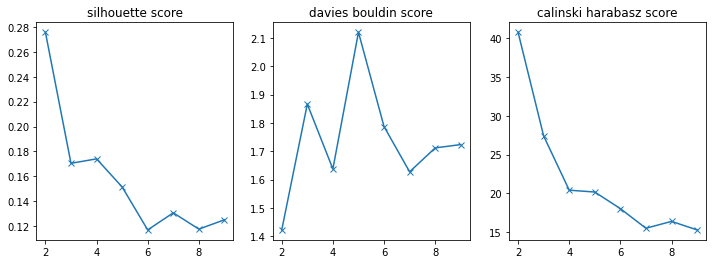

In [100]:
cluster_num = np.arange(2, 10)
plot_clustering_scores(train, cluster_num, GaussianMixture, [silhouette_score, davies_bouldin_score, calinski_harabasz_score])

Wygląda na to, że sensowny jest wybór dwóch komponentów.

In [101]:
gm = GaussianMixture(n_components=2).fit(train)

In [104]:
min_score = np.min(gm.score_samples(train))
print(min_score)

-23.925381539503217


Za próg weźmiemy najniższą średnią ważoną prawdopodobieństwa logarytmicznego. (log probability)

Teraz wyliczymy log probability dla każdej obserwacji ze zbioru testowego i za outliery uznamy te, które będą miały wynik mniejszy od `min_score`.

In [120]:
y_hat = gm.score_samples(test) < min_score
y_hat = y_hat.astype('int')

In [121]:
y_hat

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1])

In [122]:
f1 = f1_score(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
accuracy = accuracy_score(y_test, y_hat)

In [125]:
print(f'F1 Score: {f1} \nprecision: {precision} \nrecall: {recall}\naccuracy: {accuracy}')

F1 Score: 0.7272727272727272 
precision: 0.6666666666666666 
recall: 0.8
accuracy: 0.8235294117647058
